# Set up environment

In [3]:
#Import packages
import json, urllib.request, os, zipfile  
import pandas as pd 
import numpy as np
from pandas.io.json import json_normalize  
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
import geopandas as gpd
import geoplot, fiona
import geoplot.crs as gcrs
import geopy.distance
from datetime import datetime

from shapely.geometry import Polygon, shape, mapping, Point
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

# Get citibike data

In [ ]:
#Read citibike data
def get_bike_data():
    #Download
    url='https://feeds.citibikenyc.com/stations/stations.json'

    response=urllib.request.urlopen(url)
    
    #Read and extract
    bike=json.loads(response.read())

    bike=json_normalize(data=bike, record_path="stationBeanList")
    
    #Write to CSV for local access
    bike.to_csv('bike.csv')
    
    return None

get_bike_data()

# Get map data

In [ ]:
def get_map_data():
    #Download archive
    urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile", "map.zip")
    archive=zipfile.ZipFile("map.zip")
    
    #Unzip and rename
    for name in archive.namelist():
        archive.extract(name)
        oldname=name
        newname="map." + name[-3:]
        os.rename(oldname,newname)
    #Delete zip
    os.remove("map.zip")
    return None
get_map_data()

# Get accident data

In [ ]:
def get_crash_data():
    #Connect
    client = Socrata("data.cityofnewyork.us", None)
    #Download
    crash = client.get("h9gi-nx95", limit=2000000)
    crash = pd.DataFrame.from_records(crash)
    #Write to CSV for future access locally
    crash.to_csv("crash.csv")
    return None

get_crash_data()

# Explore map data

In [ ]:
#Use code snippet to transform multipolygons to polygons
import fiona
from shapely.geometry import shape, mapping

# open the original MultiPolygon file
with fiona.open('map.shp') as source:
    # create the new file: the driver and crs are the same
    # for the schema the geometry type is "Polygon" instead
    output_schema = dict(source.schema)  # make an independant copy
    output_schema['geometry'] = "Polygon"

    with fiona.open('map2.shp', 'w', 
                    driver=source.driver,
                    crs=source.crs,
                    schema=output_schema) as output:

        # read the input file
        for multi in source:

           # extract each Polygon feature
           for poly in shape(multi['geometry']):

              # write the Polygon feature
              output.write({
                  'properties': multi['properties'],
                  'geometry': mapping(poly)
              })

In [2]:
mymap=gpd.read_file("map2.shp")

In [3]:
mymap["bounds"]=mymap.geometry.apply(lambda x: x.bounds)

In [4]:
def get_bounds():
    xmin=mymap.bounds.minx.min()
    xmax=mymap.bounds.maxx.max()
    ymin=mymap.bounds.miny.min()
    ymax=mymap.bounds.maxy.max()
    return [xmin,xmax,ymin,ymax]

boundlist=get_bounds()

In [5]:
boundlist

[-74.25559136315213, -73.70000906321272, 40.49611539517034, 40.91553277600008]

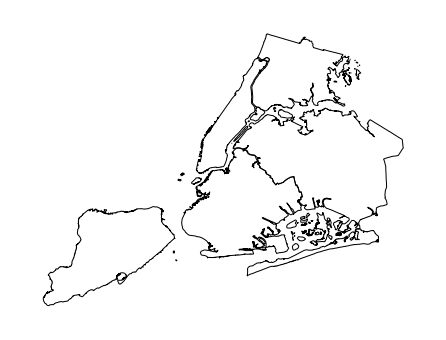

In [6]:
geoplot.polyplot(mymap)

# Explore and clean bike data

In [28]:
bike=pd.read_csv("bike.csv",index_col=0)

In [29]:
bike.describe()

,id,availableDocks,totalDocks,latitude,longitude,statusKey,availableBikes,stAddress2,city,postalCode,location,altitude,landMark
count,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,2597.243850,18.561497,31.247059,40.729521,-73.969776,1.010695,12.316578,NaN,NaN,NaN,NaN,NaN,NaN
std,1409.249936,13.342395,11.987321,0.038136,0.033958,0.145941,13.123948,NaN,NaN,NaN,NaN,NaN,NaN
min,72.000000,0.000000,0.000000,40.655400,-74.083639,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,508.500000,8.000000,23.000000,40.698513,-73.990958,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,3304.000000,18.000000,28.000000,40.723870,-73.970776,1.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,3596.500000,25.000000,39.000000,40.759318,-73.945971,1.000000,20.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,3918.000000,78.000000,79.000000,40.818299,-73.897950,3.000000,77.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
bike[bike.totalDocks==0]

,id,stationName,availableDocks,totalDocks,latitude,longitude,statusValue,statusKey,availableBikes,stAddress1,stAddress2,city,postalCode,location,altitude,testStation,lastCommunicationTime,landMark
375,3162,W 78 St & Broadway,0,0,40.783400,-73.980931,Not In Service,3,0,W 78 St & Broadway,NaN,NaN,NaN,NaN,NaN,False,1969-12-31 07:00:00 PM,NaN
906,3881,12 Ave & W 125 St,0,0,40.818299,-73.960405,Not In Service,3,0,12 Ave & W 125 St,NaN,NaN,NaN,NaN,NaN,False,2020-01-23 08:16:13 AM,NaN


In [31]:
bike.statusValue.unique()

array(['In Service', 'Not In Service'], dtype=object)

In [32]:
bike[bike.statusKey==3]

,id,stationName,availableDocks,totalDocks,latitude,longitude,statusValue,statusKey,availableBikes,stAddress1,stAddress2,city,postalCode,location,altitude,testStation,lastCommunicationTime,landMark
109,342,Columbia St & Rivington St,7,29,40.717400,-73.980166,Not In Service,3,22,Columbia St & Rivington St,NaN,NaN,NaN,NaN,NaN,False,2020-01-28 10:11:02 AM,NaN
268,2010,Grand St & Greene St,2,3,40.721655,-74.002347,Not In Service,3,0,Grand St & Greene St,NaN,NaN,NaN,NaN,NaN,False,2019-09-01 01:30:49 PM,NaN
375,3162,W 78 St & Broadway,0,0,40.783400,-73.980931,Not In Service,3,0,W 78 St & Broadway,NaN,NaN,NaN,NaN,NaN,False,1969-12-31 07:00:00 PM,NaN
906,3881,12 Ave & W 125 St,0,0,40.818299,-73.960405,Not In Service,3,0,12 Ave & W 125 St,NaN,NaN,NaN,NaN,NaN,False,2020-01-23 08:16:13 AM,NaN
934,3918,Avenue D & E 8 St,27,30,40.723870,-73.975767,Not In Service,3,2,Avenue D & E 8 St,NaN,NaN,NaN,NaN,NaN,False,2020-01-28 07:23:22 AM,NaN


In [33]:
bike.columns

Index(['id', 'stationName', 'availableDocks', 'totalDocks', 'latitude',
       'longitude', 'statusValue', 'statusKey', 'availableBikes', 'stAddress1',
       'stAddress2', 'city', 'postalCode', 'location', 'altitude',
       'testStation', 'lastCommunicationTime', 'landMark'],
      dtype='object')

In [34]:
for col in ['stAddress2', 'city', 'postalCode', 'location', 'altitude', 'landMark', 'testStation']:
    print(bike[col].unique())

[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[False]


In [35]:
#Delete empty columns
bike.drop(['stAddress2', 'city', 'postalCode', 'location', 'altitude', 'landMark', 'testStation'],axis=1, inplace=True)

In [114]:
#There are stations outside the boroughs, find and drop them
mymap=gpd.read_file("map2.shp")
#Create dictionary of borough polygons and names
mapdict=mymap["geometry"].to_dict()
borodict=mymap["boro_name"].to_dict()
#Function to find borough name by coordinate
def borough_find(coord):
    for i in range(len(mapdict)):
        if coord.within(mapdict[i]):
            return borodict[i].upper()
bike= gpd.GeoDataFrame(bike, geometry=gpd.points_from_xy(bike.longitude, bike.latitude))

In [116]:
bike["borough"]=bike.geometry.apply(borough_find)

In [124]:
bike.dropna(subset=["borough"],inplace=True)

In [126]:
bike.borough.unique()

array(['MANHATTAN', 'BROOKLYN', 'QUEENS'], dtype=object)

In [127]:
bike.to_csv("bike_cleaned.csv")

# Explore and clean crash data

In [7]:
#Read and preprocess data
#Make strings lower case
f=lambda x: x.lower() if len(x)>0 else np.nan
crash=pd.read_csv("crash.csv", index_col=0, low_memory=False, converters={"vehicle_type_code1":f,"vehicle_type_code2":f, "vehicle_type_code_3":f, "vehicle_type_code_4":f,"vehicle_type_code_5":f})

/Users/tamasbarko/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
crash.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,1443074.0,4.069258e+01,1.133296e+00,0.00000,4.066880e+01,4.072255e+01,4.076803e+01,4.334444e+01
longitude,1443074.0,-7.387308e+01,2.330433e+00,-201.35999,-7.397705e+01,-7.392943e+01,-7.386680e+01,0.000000e+00
number_of_persons_injured,1642418.0,2.633818e-01,6.602323e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01
number_of_persons_killed,1642404.0,1.170845e-03,3.611983e-02,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00
number_of_pedestrians_injured,1642435.0,5.091708e-02,2.323560e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,2.700000e+01
number_of_pedestrians_killed,1642435.0,6.405124e-04,2.587136e-02,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
number_of_cyclist_injured,1642435.0,2.062730e-02,1.432851e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
number_of_cyclist_killed,1642435.0,8.341274e-05,9.199105e-03,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
number_of_motorist_injured,1642435.0,1.919759e-01,6.226159e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01
number_of_motorist_killed,1642435.0,4.493329e-04,2.303731e-02,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00


In [9]:
#Some coordinates are clearly wrong, e.g., -200 longitude (out of bounds) or 0 latitude (equator)
#Check outside New Jersey and Long Island (East-West)
#latitude is positive
crash.latitude=np.where(((crash.latitude>boundlist[3]) | (crash.latitude<boundlist[2])), np.nan, crash.latitude)
#longitude is negative
crash.longitude=np.where(((crash.longitude>boundlist[1]) | (crash.longitude<boundlist[0])), np.nan, crash.longitude)

In [10]:
#Bike casualty
crash["bike_casualty"]=(crash.number_of_cyclist_injured>0) | (crash.number_of_cyclist_killed>0)


In [11]:
crash.bike_casualty.astype(int).mean()

0.02055119380675643

In [12]:
#Any bike injury with unknown vehicle
#Maybe you get hit by something other than a vehicle (wind, loose object, etc.) when parking/picking up your bike
print(crash["number_of_cyclist_injured"][(crash.vehicle_type_code1.isna()) & 
                                         (crash.vehicle_type_code2.isna()) & (crash.vehicle_type_code_3.isna()) & 
                                         (crash.vehicle_type_code_4.isna()) & (crash.vehicle_type_code_5.isna()) & 
                                         (crash.number_of_cyclist_injured>0)])
print(crash[["number_of_cyclist_killed"]][(crash.vehicle_type_code1.isna()) & 
                                          (crash.vehicle_type_code2.isna()) & (crash.vehicle_type_code_3.isna()) &
                                          (crash.vehicle_type_code_4.isna()) & (crash.vehicle_type_code_5.isna()) & 
                                          (crash.number_of_cyclist_killed>0)])

crash["bike_involved"]=((crash.vehicle_type_code1.isna()) & (crash.vehicle_type_code2.isna()) & 
                             (crash.vehicle_type_code_3.isna()) & (crash.vehicle_type_code_4.isna()) & 
                             (crash.vehicle_type_code_5.isna()) & 
                        ((crash.number_of_cyclist_injured>0) | crash.number_of_cyclist_killed>0))

669965     1
809395     1
1363736    1
1369031    1
1374247    1
1400182    1
1402853    1
1408448    1
1413660    1
1414335    1
1416811    1
1426901    1
1428933    1
1442401    1
1489994    1
1497189    1
1500286    1
1500681    1
1514394    1
Name: number_of_cyclist_injured, dtype: int64
Empty DataFrame
Columns: [number_of_cyclist_killed]
Index: []


In [13]:
#Drop if no vehicle or bike is involved
#Recode bike involvement to NaN if false
crash.bike_involved.replace(False, np.nan, inplace=True)

crash.dropna(subset=["vehicle_type_code1","vehicle_type_code2", "vehicle_type_code_3",
                    "vehicle_type_code_4","vehicle_type_code_5","bike_involved"],thresh=1,inplace=True)

#Convert bike involvement back to boolean
crash.bike_involved.fillna(0,inplace=True)
crash.bike_involved=crash.bike_involved.astype(bool)

In [14]:
#Get an idea for the labeling of "bike"
vehicle_list=['vehicle_type_code1','vehicle_type_code2',
            'vehicle_type_code_3', 'vehicle_type_code_4','vehicle_type_code_5']

for col in vehicle_list:
    print(crash[col][(crash.number_of_cyclist_injured>0 )| (crash.number_of_cyclist_killed>0)].unique())

['station wagon/sport utility vehicle' 'taxi' 'sedan' 'pick-up truck'
 'bike' 'ambulance' 'bus' 'van' 'motorcycle' 'box truck' 'pk' 'moped'
 'convertible' 'mta b' 'tractor truck diesel' 'garbage or refuse'
 '4 dr sedan' 'limo' 'concrete mixer' 'e-bik' 'usps' 'pedicab' 'flat bed'
 'dump' 'open body' 'horse' 'carry all' 'comme' 'pallet' 'ambul' 'acces'
 'tanker' 'self' 'e-sco' 'tow truck / wrecker' 'lmb' 'unkno' 'flat rack'
 'dumps' 'passenger vehicle' 'small com veh(4 tires) '
 'sport utility / station wagon' 'unknown' 'bicycle' 'livery vehicle'
 'large com veh(6 or more tires)' 'other' 'motorscooter' 'golf' 'truck'
 'utv' 'deliv' 'psd' 'motor' 'tractor truck gasoline' 'skate' 'bu'
 'motorbike' 'e sco' 'rf' 'armored truck' 'fire' 'dp' 'fire truck' 'vn'
 'tk' 'conv' 'ms' 'tn' nan 'ds' 'new y' 'fb' 'schoo' 'scooter']
['bike' 'taxi' 'station wagon/sport utility vehicle' 'sedan' 'bus' nan
 'motorcycle' 'bycic' 'box truck' 'throt' 'pick-up truck' 'beverage truck'
 'e-bik' 'pedicab' 'limo' 'c

In [15]:
#Representations of bike 4 char
bike_name=["bike","byke","bicy","byci","bici","bycy","e-bi","e bi","e-by","e by","cycl","cicl"]

#Shorten vehicle name to 4 characters
crash[vehicle_list]=crash[vehicle_list].applymap(lambda x: x[:4] if type(x)==str else x)

In [16]:
#Check if any vehicle label resembles bike label
crash[vehicle_list]=crash[vehicle_list].isin(bike_name)

In [17]:
#Create indicator variable for bike crash
crash["bike_crash"]=crash[vehicle_list].any(axis=1)

In [18]:
crash[(crash.bike_casualty==True) | (crash.bike_involved==True) | (crash.bike_crash==True)].describe()

,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,collision_id
count,40879.000000,40879.000000,44422.000000,44422.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,44424.000000,4.442400e+04
mean,40.724914,-73.942022,0.812435,0.003489,0.029399,0.000270,0.762628,0.003084,0.020259,0.000135,2.778286e+06
std,0.066540,0.058852,0.461752,0.068832,0.176610,0.030747,0.439530,0.055852,0.190597,0.011621,1.554492e+06
min,40.505013,-74.248280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.700000e+01
25%,40.680188,-73.983071,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.012582e+06
50%,40.725070,-73.953466,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.504367e+06
75%,40.762234,-73.913079,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.917206e+06
max,40.910900,-73.700990,22.000000,8.000000,7.000000,6.000000,4.000000,2.000000,21.000000,1.000000,4.279453e+06


In [19]:
#No location information
crash[(crash.borough.isna()) & (crash.longitude.isna())].count()

crash_date                       170141
crash_time                       170141
latitude                            133
longitude                             0
location                            399
on_street_name                   121791
off_street_name                  100285
number_of_persons_injured        170139
number_of_persons_killed         170138
number_of_pedestrians_injured    170141
number_of_pedestrians_killed     170141
number_of_cyclist_injured        170141
number_of_cyclist_killed         170141
number_of_motorist_injured       170141
number_of_motorist_killed        170141
contributing_factor_vehicle_1    169836
contributing_factor_vehicle_2    151323
collision_id                     170141
vehicle_type_code1               170141
vehicle_type_code2               170141
borough                               0
zip_code                              0
cross_street_name                 18081
contributing_factor_vehicle_3     12093
contributing_factor_vehicle_4      2374


In [20]:
#Generate corner information
#Remove leading/trailing spaces
crash.on_street_name=crash.on_street_name.str.strip()
crash.off_street_name=crash.off_street_name.str.strip()
crash["corner"]=crash.on_street_name+crash.off_street_name
crash["corner"]=crash.corner.fillna("other_unknown_street")
#Save if there was no geodata
crash["no_geo"]=(crash.latitude.isna())
#Fill coordinate with corner coordinate mean
crash.latitude=crash.groupby(['corner'])['latitude'].transform(lambda x: x.fillna(x.mean()))
crash.longitude=crash.groupby(['corner'])['longitude'].transform(lambda x: x.fillna(x.mean()))
#Fill back unknown info with NaN to avoid potential distortion
crash.longitude=np.where(((crash.corner=="other_unknown_street") & (crash.no_geo==True)),np.nan,crash.longitude)
crash.latitude=np.where(((crash.corner=="other_unknown_street") & (crash.no_geo==True)),np.nan,crash.latitude)


In [21]:
#Check if coordinates still make sense
crash[["latitude","longitude"]].describe()

,latitude,longitude
count,1.533605e+06,1.533605e+06
mean,4.072386e+01,-7.392081e+01
std,7.828670e-02,8.763861e-02
min,4.049895e+01,-7.425453e+01
25%,4.066913e+01,-7.397670e+01
50%,4.072239e+01,-7.392847e+01
75%,4.076796e+01,-7.386490e+01
max,4.091288e+01,-7.370055e+01


In [22]:
boundlist

[-74.25559136315213, -73.70000906321272, 40.49611539517034, 40.91553277600008]

In [23]:
#Check remaining location information
crash.location[(crash.borough.isna()) & (crash.longitude.isna() & (crash.location.isna()==False))].unique()

array(["{'type': 'Point', 'coordinates': [0, 0]}",
       "{'type': 'Point', 'coordinates': [-73.755936, 42.318317]}",
       "{'type': 'Point', 'coordinates': [-89.13527, 30.78418]}",
       "{'type': 'Point', 'coordinates': [-76.02163, 42.107204]}",
       "{'type': 'Point', 'coordinates': [-79.00183, 42.64154]}",
       "{'type': 'Point', 'coordinates': [-86.76847, 34.783634]}",
       "{'type': 'Point', 'coordinates': [-76.2634, 43.344444]}",
       "{'type': 'Point', 'coordinates': [-73.97066, 41.061634]}",
       "{'type': 'Point', 'coordinates': [-73.71412, 41.12421]}",
       "{'type': 'Point', 'coordinates': [-73.99024, 41.258785]}",
       "{'type': 'Point', 'coordinates': [-79.61955, 41.91661]}",
       "{'type': 'Point', 'coordinates': [-73.96965, 41.34796]}",
       "{'type': 'Point', 'coordinates': [-73.71353, 41.12615]}"],
      dtype=object)

In [24]:
#No location information
crash[(crash.borough.isna()) & (crash.longitude.isna())].count()

crash_date                       93451
crash_time                       93451
latitude                             0
longitude                            0
location                           198
on_street_name                   45099
off_street_name                  23719
number_of_persons_injured        93449
number_of_persons_killed         93449
number_of_pedestrians_injured    93451
number_of_pedestrians_killed     93451
number_of_cyclist_injured        93451
number_of_cyclist_killed         93451
number_of_motorist_injured       93451
number_of_motorist_killed        93451
contributing_factor_vehicle_1    93283
contributing_factor_vehicle_2    82524
collision_id                     93451
vehicle_type_code1               93451
vehicle_type_code2               93451
borough                              0
zip_code                             0
cross_street_name                18056
contributing_factor_vehicle_3     7925
contributing_factor_vehicle_4     1617
vehicle_type_code_3      

In [25]:
#Drop accidents with no location data and temp columns
crash.dropna(subset=["latitude"],inplace=True)
crash.drop(["corner","no_geo"],axis=1,inplace=True)

In [26]:
crash.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,1533605.0,4.072386e+01,7.828670e-02,40.498949,4.066913e+01,4.072239e+01,4.076796e+01,4.091288e+01
longitude,1533605.0,-7.392081e+01,8.763861e-02,-74.254532,-7.397670e+01,-7.392847e+01,-7.386490e+01,-7.370055e+01
number_of_persons_injured,1533591.0,2.623868e-01,6.582843e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01
number_of_persons_killed,1533580.0,1.160031e-03,3.603094e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00
number_of_pedestrians_injured,1533605.0,5.075622e-02,2.322815e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.700000e+01
number_of_pedestrians_killed,1533605.0,6.403213e-04,2.588255e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
number_of_cyclist_injured,1533605.0,2.131057e-02,1.454882e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
number_of_cyclist_killed,1533605.0,8.541965e-05,9.312171e-03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
number_of_motorist_injured,1533605.0,1.904402e-01,6.199909e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01
number_of_motorist_killed,1533605.0,4.342709e-04,2.272096e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00


In [ ]:
crash.collision_id.nunique()-crash.collision_id.count()

In [ ]:
crash.borough.unique()

In [27]:
crash=gpd.GeoDataFrame(crash, geometry=gpd.points_from_xy(crash.longitude, crash.latitude))

In [28]:
crash.head()

,crash_date,crash_time,latitude,longitude,location,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,vehicle_type_code_3,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5,bike_casualty,bike_involved,bike_crash,geometry
0,2019-06-08T00:00:00.000,21:00,40.660770,-73.895510,"{'type': 'Point', 'coordinates': [-73.89551, 4...",NEW LOTS AVENUE,ALABAMA AVENUE,0.0,0.0,0,...,NaN,NaN,False,False,NaN,False,False,False,False,POINT (-73.89551 40.66077)
1,2019-06-26T00:00:00.000,11:30,40.658413,-74.003570,"{'type': 'Point', 'coordinates': [-74.00357, 4...",31 STREET,3 AVENUE,0.0,0.0,0,...,NaN,NaN,False,False,NaN,False,False,False,False,POINT (-74.00357 40.65841)
2,2019-06-17T00:00:00.000,1:05,40.696686,-73.937800,"{'type': 'Point', 'coordinates': [-73.9378, 40...",LEWIS AVENUE,NaN,1.0,0.0,0,...,NaN,NaN,False,False,NaN,False,False,False,False,POINT (-73.93780 40.69669)
3,2019-06-28T00:00:00.000,10:30,40.758587,-73.919334,"{'type': 'Point', 'coordinates': [-73.919334, ...",NaN,NaN,0.0,0.0,0,...,NaN,NaN,False,False,NaN,False,False,False,False,POINT (-73.91933 40.75859)
4,2019-06-08T00:00:00.000,13:20,40.895374,-73.863560,"{'type': 'Point', 'coordinates': [-73.86356, 4...",WEBSTER AVENUE,EAST 233 STREET,0.0,0.0,0,...,Unspecified,Unspecified,False,False,NaN,False,False,False,False,POINT (-73.86356 40.89537)


In [81]:
mymap.boro_name.unique()

array(['Bronx', 'Staten Island', 'Brooklyn', 'Queens', 'Manhattan'],
      dtype=object)

In [30]:
#Create dictionary of borough polygons and names
mapdict=mymap["geometry"].to_dict()
borodict=mymap["boro_name"].to_dict()

In [103]:
#Function to find borough name by coordinate
def borough_find(coord):
    for i in range(len(mapdict)):
        if coord.within(mapdict[i]):
            return borodict[i].upper()

In [104]:
borough_df=crash[["borough","geometry"]][crash.borough.isna()==True]

In [105]:
borough_df["bor_new"]=borough_df.geometry.apply(borough_find)

In [107]:
borough_df.to_csv("borough_new")

In [108]:
borough_df.head()

,borough,geometry,bor_new
0,NaN,POINT (-73.89551 40.66077),BROOKLYN
2,NaN,POINT (-73.93780 40.69669),BROOKLYN
14,NaN,POINT (-73.87245 40.82377),BRONX
20,NaN,POINT (-73.98418 40.58353),BROOKLYN
23,NaN,POINT (-73.94833 40.71786),BROOKLYN


In [109]:
crash=pd.merge(crash,borough_df.bor_new,how="left", left_index=True, right_index=True)

In [111]:
crash.borough=crash.borough.str.strip()
crash.bor_new=crash.bor_new.str.strip()

In [114]:
crash["boroughs"]=np.where(crash.borough.isna()==True,crash.bor_new,crash.borough)

In [115]:
crash.boroughs.unique()

array(['BROOKLYN', 'QUEENS', 'BRONX', 'MANHATTAN', 'STATEN ISLAND', None],
      dtype=object)

In [116]:
crash.to_csv("crash_cleaned.csv")

# Q1: What is the most dangerous borough to own a bike in?

In [47]:
crash=pd.read_csv("crash_cleaned.csv",index_col=0,low_memory=False)
crash.head()

/Users/tamasbarko/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,crash_date,crash_time,latitude,longitude,location,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,vehicle_type_code_3,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5,bike_casualty,bike_involved,bike_crash,geometry,bor_new,boroughs
0,2019-06-08T00:00:00.000,21:00,40.660770,-73.895510,"{'type': 'Point', 'coordinates': [-73.89551, 4...",NEW LOTS AVENUE,ALABAMA AVENUE,0.0,0.0,0,...,False,False,NaN,False,False,False,False,POINT (-73.89551 40.66077),BROOKLYN,BROOKLYN
1,2019-06-26T00:00:00.000,11:30,40.658413,-74.003570,"{'type': 'Point', 'coordinates': [-74.00357, 4...",31 STREET,3 AVENUE,0.0,0.0,0,...,False,False,NaN,False,False,False,False,POINT (-74.00357 40.658413),NaN,BROOKLYN
2,2019-06-17T00:00:00.000,1:05,40.696686,-73.937800,"{'type': 'Point', 'coordinates': [-73.9378, 40...",LEWIS AVENUE,NaN,1.0,0.0,0,...,False,False,NaN,False,False,False,False,POINT (-73.9378 40.696686),BROOKLYN,BROOKLYN
3,2019-06-28T00:00:00.000,10:30,40.758587,-73.919334,"{'type': 'Point', 'coordinates': [-73.919334, ...",NaN,NaN,0.0,0.0,0,...,False,False,NaN,False,False,False,False,POINT (-73.91933399999999 40.758587),NaN,QUEENS
4,2019-06-08T00:00:00.000,13:20,40.895374,-73.863560,"{'type': 'Point', 'coordinates': [-73.86356, 4...",WEBSTER AVENUE,EAST 233 STREET,0.0,0.0,0,...,False,False,NaN,False,False,False,False,POINT (-73.86355999999999 40.895374),NaN,BRONX


In [24]:
simple_map=gpd.read_file("map.shp")
simple_map.boro_name=simple_map.boro_name.apply(lambda x: x.upper())
simple_map=pd.merge(simple_map,crash.groupby(["boroughs"])["bike_crash"].sum(), 
                    left_on="boro_name",right_on="boroughs",how="inner")

In [25]:
simple_map

,boro_code,boro_name,shape_area,shape_leng,geometry,bike_crash
0,2.0,BRONX,1.186612e+09,462958.187332,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",3980.0
1,5.0,STATEN ISLAND,1.623756e+09,325960.628294,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",566.0
2,3.0,BROOKLYN,1.937593e+09,738745.840717,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",15958.0
3,4.0,QUEENS,3.045878e+09,904188.424111,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...",7917.0
4,1.0,MANHATTAN,6.366027e+08,361212.476577,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",14336.0


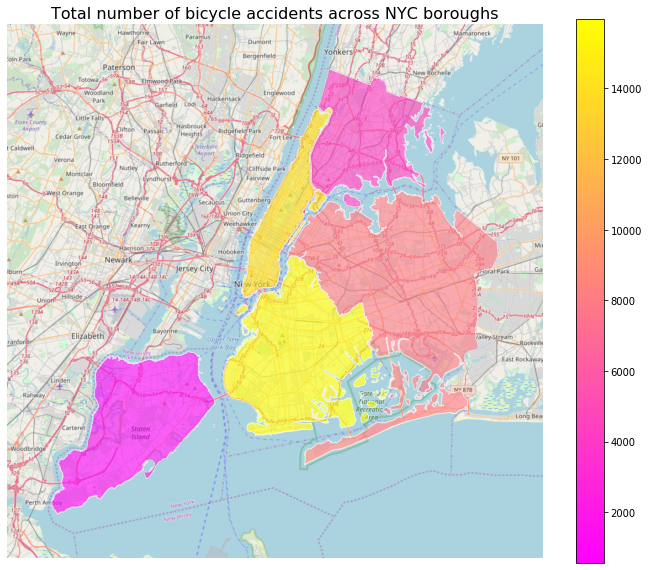

In [26]:
ax = geoplot.webmap(simple_map, projection=gcrs.WebMercator(),figsize=(12,10))
geoplot.choropleth(
    simple_map, projection=geoplot.crs.WebMercator(),
    hue='bike_crash', cmap='spring', scheme=None,
    legend=True,
    edgecolor='white', ax=ax, alpha=0.6
)
plt.title("Total number of bicycle accidents across NYC boroughs",size=16)

plt.savefig("bike_crashes.png")


In [52]:
#Create new variables - time fixed effect
#Year
crash["year"]=pd.to_datetime(crash.crash_date)
crash["year"]=crash.year.apply(lambda x: x.strftime("%Y"))

In [51]:
summary=crash.groupby(["borough","year"])["bike_crash"].sum()

In [65]:
crash.head()

,crash_date,crash_time,latitude,longitude,location,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5,bike_casualty,bike_involved,bike_crash,geometry,bor_new,boroughs,year
0,2019-06-08T00:00:00.000,21:00,40.660770,-73.895510,"{'type': 'Point', 'coordinates': [-73.89551, 4...",NEW LOTS AVENUE,ALABAMA AVENUE,0.0,0.0,0,...,False,NaN,False,False,False,False,POINT (-73.89551 40.66077),BROOKLYN,BROOKLYN,2019
1,2019-06-26T00:00:00.000,11:30,40.658413,-74.003570,"{'type': 'Point', 'coordinates': [-74.00357, 4...",31 STREET,3 AVENUE,0.0,0.0,0,...,False,NaN,False,False,False,False,POINT (-74.00357 40.658413),NaN,BROOKLYN,2019
2,2019-06-17T00:00:00.000,1:05,40.696686,-73.937800,"{'type': 'Point', 'coordinates': [-73.9378, 40...",LEWIS AVENUE,NaN,1.0,0.0,0,...,False,NaN,False,False,False,False,POINT (-73.9378 40.696686),BROOKLYN,BROOKLYN,2019
3,2019-06-28T00:00:00.000,10:30,40.758587,-73.919334,"{'type': 'Point', 'coordinates': [-73.919334, ...",NaN,NaN,0.0,0.0,0,...,False,NaN,False,False,False,False,POINT (-73.91933399999999 40.758587),NaN,QUEENS,2019
4,2019-06-08T00:00:00.000,13:20,40.895374,-73.863560,"{'type': 'Point', 'coordinates': [-73.86356, 4...",WEBSTER AVENUE,EAST 233 STREET,0.0,0.0,0,...,False,NaN,False,False,False,False,POINT (-73.86355999999999 40.895374),NaN,BRONX,2019


In [72]:
crash.boroughs.unique()

array(['BROOKLYN', 'QUEENS', 'BRONX', 'MANHATTAN', 'STATEN ISLAND', nan],
      dtype=object)

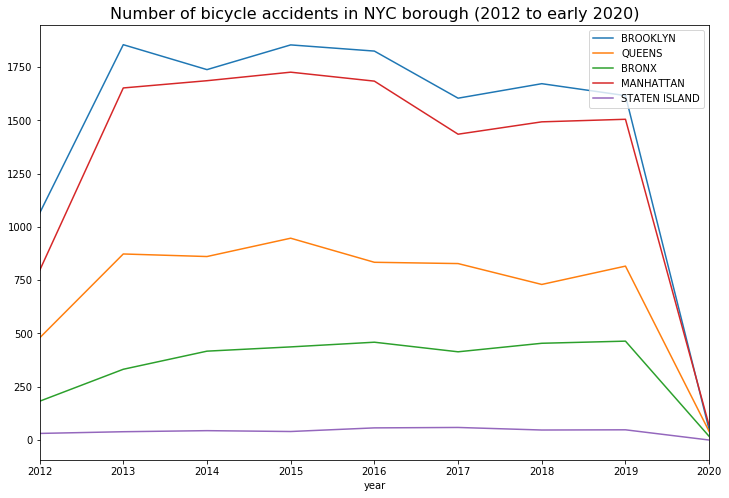

In [82]:
for bor in ['BROOKLYN', 'QUEENS', 'BRONX', 'MANHATTAN', 'STATEN ISLAND']:
    summary.xs(bor).plot(kind="line", label=bor, figsize=(12,8))
    
plt.legend()
plt.plot()
plt.title("Number of bicycle accidents in NYC borough (2012 to early 2020)", size=16)
plt.savefig("accidents_over_time.png")

# Q2: What is the worst place to have a citibike station?

In [2]:
#Create coordinate array from bike crashes, latitude first
crash=pd.read_csv("crash_cleaned.csv", index_col=0,low_memory=False)
crashcoordlist=crash[["latitude","longitude"]][crash.bike_crash==True].to_numpy()
index_for_station=crash[crash.bike_crash==True].index

/Users/tamasbarko/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
len(crashcoordlist)

42797

In [37]:
#Create coordinate array from bike stations,latitude first
bike=pd.read_csv("bike_cleaned.csv",index_col=0)
coordlist=bike[["latitude","longitude"]].to_numpy()

In [5]:
#Function that finds nearest station to crash by distance and returns distance and citibike station index
def station_finder():
    result={}
    for i in range(len(crashcoordlist)):
        #Define nested function to avoid matching shape of coordinates to bike station array
        def dist_calc(a):
            return geopy.distance.distance((a[0],a[1]),(crashcoordlist[i][0],crashcoordlist[i][1])).km
        dist=np.apply_along_axis(dist_calc,1,coordlist)
        #Key is crash index, value is station row (index in bike DF) and distance
        result[index_for_station[i]]=[dist.argmin(),dist.min()]
    return result    

In [6]:
station_crash_dist=station_finder()

In [7]:
st_crash_df=pd.DataFrame(list(station_crash_dist.items()))

In [8]:
st_crash_df.set_index(0, inplace=True)

In [9]:
st_crash_df["citi_id"]=st_crash_df[1].apply(lambda x: x[0])
st_crash_df["distance"]=st_crash_df[1].apply(lambda x: x[1])
st_crash_df=st_crash_df[["citi_id","distance"]]

In [10]:
st_crash_df.groupby(("citi_id")).count()

,distance
citi_id,
0,45
1,40
2,113
3,32
4,48
...,...
877,231
878,18
879,32


In [ ]:
st_crash_df.to_csv("accident_to_station.csv")

In [40]:
st_crash_df=pd.read_csv("accident_to_station.csv",index_col=0)
station_crash=pd.merge(bike,st_crash_df.groupby(("citi_id")).count(),how="left",left_index=True, right_index=True)
station_crash.rename({"distance":"count"},axis=1,inplace=True)

In [42]:
station_crash.sort_values("count", ascending=False)

,id,stationName,availableDocks,totalDocks,latitude,longitude,statusValue,statusKey,availableBikes,stAddress1,lastCommunicationTime,geometry,borough,count
555,3397,Court St & Nelson St,4,25,40.676395,-73.998699,In Service,1,21,Court St & Nelson St,2020-01-28 10:10:49 AM,POINT (-73.99869893 40.6763947),BROOKLYN,2641.0
849,3824,Van Sinderen Ave & Truxton St,18,23,40.678600,-73.903690,In Service,1,5,Van Sinderen Ave & Truxton St,2020-01-28 10:12:46 AM,POINT (-73.90369 40.6786),BROOKLYN,2172.0
595,3477,39 St & 2 Ave,0,33,40.655400,-74.010628,In Service,1,33,39 St & 2 Ave,2020-01-28 10:12:05 AM,POINT (-74.01062786579131 40.65539977447831),BROOKLYN,1960.0
573,3418,Plaza St West & Flatbush Ave,13,33,40.675021,-73.971115,In Service,1,20,Plaza St West & Flatbush Ave,2020-01-28 10:10:15 AM,POINT (-73.97111473 40.6750207),BROOKLYN,1817.0
797,3757,Stagg St & Morgan Ave,5,23,40.710681,-73.933720,In Service,1,18,Stagg St & Morgan Ave,2020-01-28 10:11:28 AM,POINT (-73.93371999999999 40.710681),BROOKLYN,1690.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,3910,Greene Ave & Grandview Ave,17,17,40.709697,-73.907856,In Service,1,0,Greene Ave & Grandview Ave,2020-01-28 10:11:31 AM,POINT (-73.90785600000001 40.709697),QUEENS,NaN
931,3911,Wyckoff St & Nevins St,12,22,40.683426,-73.984275,In Service,1,10,Wyckoff St & Nevins St,2020-01-28 10:11:39 AM,POINT (-73.984275 40.683426),BROOKLYN,NaN
932,3916,Pearl St & Peck Slip,13,43,40.708485,-74.002751,In Service,1,30,Pearl St & Peck Slip,2020-01-28 10:12:05 AM,POINT (-74.002751 40.708485),MANHATTAN,NaN
933,3917,Willoughby St & Ashland Pl,29,31,40.691780,-73.978770,In Service,1,2,Willoughby St & Ashland Pl,2020-01-28 10:11:07 AM,POINT (-73.97877 40.69178),BROOKLYN,NaN


In [13]:
crash_map= gpd.GeoDataFrame(
    station_crash["count"], geometry=gpd.points_from_xy(station_crash.longitude, station_crash.latitude))

In [14]:
crash_map

,count,geometry
0,45.0,POINT (-73.97499 40.75510)
1,40.0,POINT (-73.97069 40.75828)
2,113.0,POINT (-73.98955 40.74034)
3,32.0,POINT (-73.99468 40.75059)
4,48.0,POINT (-73.97982 40.76133)
...,...,...
930,NaN,POINT (-73.90786 40.70970)
931,NaN,POINT (-73.98427 40.68343)
932,NaN,POINT (-74.00275 40.70849)
933,NaN,POINT (-73.97877 40.69178)


In [16]:
simple_map=gpd.read_file("map2.shp")

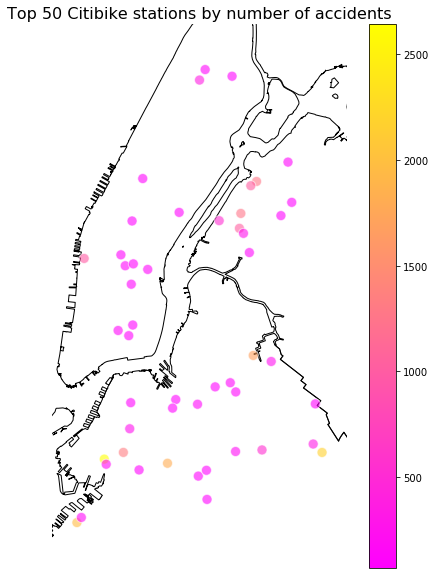

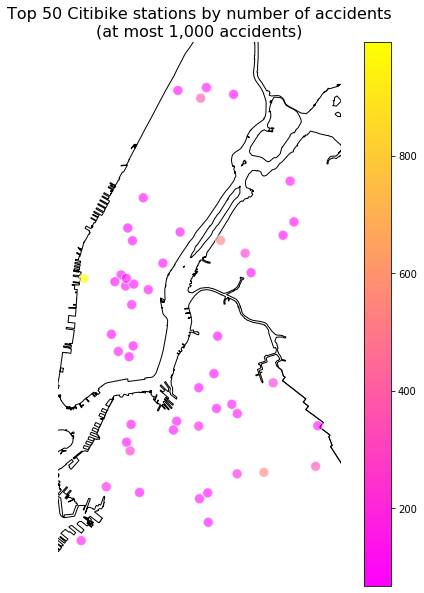

In [33]:
#Plot stations
ax = geoplot.polyplot(simple_map, projection=gcrs.WebMercator(),figsize=(8,10))
geoplot.pointplot(
    crash_map.sort_values("count",ascending=False).head(50), projection=geoplot.crs.WebMercator(),
    hue='count', cmap='spring', scheme=None,
    legend=True,
    edgecolor='white', ax=ax, alpha=0.6, s=10
)
plt.title("Top 50 Citibike stations by number of accidents",size=16)

plt.savefig("bike_crashes_near_station.png")

ax = geoplot.polyplot(simple_map, projection=gcrs.WebMercator(),figsize=(8,10))
geoplot.pointplot(
    crash_map[(crash_map["count"]<=1000)].sort_values("count",ascending=False).head(50), projection=geoplot.crs.WebMercator(),
    hue='count', cmap='spring', scheme=None,
    legend=True,
    edgecolor='white', ax=ax, alpha=0.6, s=10
)
plt.title("Top 50 Citibike stations by number of accidents\n(at most 1,000 accidents)",size=16)

plt.savefig("bike_crashes_near_station_truncated.png")

# Q3: Create a model to predict where can be an accident and how close it is to the nearest bike station

In [4]:
crash=pd.read_csv("crash_cleaned.csv",low_memory=False,index_col=0)

/Users/tamasbarko/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
crash.bike_crash.astype(int).sum()/len(crash)

0.02790614271601879

In [6]:
crash.bike_crash=crash.bike_crash.astype(int)

In [7]:
keeplist=['crash_date', 'crash_time', 'latitude', 'longitude','number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed','bike_crash', 'geometry','boroughs']

In [8]:
crash.dropna(subset=keeplist,inplace=True)

In [9]:
crash=crash[keeplist]
crash.head()

,crash_date,crash_time,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,bike_crash,geometry,boroughs
0,2019-06-08T00:00:00.000,21:00,40.660770,-73.895510,0.0,0.0,0,0,0,POINT (-73.89551 40.66077),BROOKLYN
1,2019-06-26T00:00:00.000,11:30,40.658413,-74.003570,0.0,0.0,0,0,0,POINT (-74.00357 40.658413),BROOKLYN
2,2019-06-17T00:00:00.000,1:05,40.696686,-73.937800,1.0,0.0,0,0,0,POINT (-73.9378 40.696686),BROOKLYN
3,2019-06-28T00:00:00.000,10:30,40.758587,-73.919334,0.0,0.0,0,0,0,POINT (-73.91933399999999 40.758587),QUEENS
4,2019-06-08T00:00:00.000,13:20,40.895374,-73.863560,0.0,0.0,0,0,0,POINT (-73.86355999999999 40.895374),BRONX


In [10]:
#Create new variables - time fixed effect
#Year
crash["year"]=pd.to_datetime(crash.crash_date)
crash["year"]=crash.year.apply(lambda x: x.strftime("%Y"))

In [11]:
#Month
crash["month"]=pd.to_datetime(crash.crash_date)
crash["month"]=crash.month.apply(lambda x: x.strftime("%m"))

In [12]:
#Weekend
crash["weekend"]=pd.to_datetime(crash.crash_date)
crash["weekend"]=crash.weekend.apply(lambda x: 1 if (int(x.strftime("%w"))==0 or int(x.strftime("%w"))==6) else 0)

In [13]:
#Morning
crash["morning"]=crash.crash_time.apply(lambda x: 1 if (datetime.strptime(x,"%H:%M").hour >=6 and
                                                     datetime.strptime(x,"%H:%M").hour <12) else 0)
#Afternoon
crash["afternoon"]=crash.crash_time.apply(lambda x: 1 if (datetime.strptime(x,"%H:%M").hour >=12 and
                                                     datetime.strptime(x,"%H:%M").hour <18) else 0)

In [14]:
crash.head()

,crash_date,crash_time,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,bike_crash,geometry,boroughs,year,month,weekend,morning,afternoon
0,2019-06-08T00:00:00.000,21:00,40.660770,-73.895510,0.0,0.0,0,0,0,POINT (-73.89551 40.66077),BROOKLYN,2019,06,1,0,0
1,2019-06-26T00:00:00.000,11:30,40.658413,-74.003570,0.0,0.0,0,0,0,POINT (-74.00357 40.658413),BROOKLYN,2019,06,0,1,0
2,2019-06-17T00:00:00.000,1:05,40.696686,-73.937800,1.0,0.0,0,0,0,POINT (-73.9378 40.696686),BROOKLYN,2019,06,0,0,0
3,2019-06-28T00:00:00.000,10:30,40.758587,-73.919334,0.0,0.0,0,0,0,POINT (-73.91933399999999 40.758587),QUEENS,2019,06,0,1,0
4,2019-06-08T00:00:00.000,13:20,40.895374,-73.863560,0.0,0.0,0,0,0,POINT (-73.86355999999999 40.895374),BRONX,2019,06,1,0,1


In [15]:
X=crash.drop("bike_crash",axis=1)
y=crash["bike_crash"]

In [16]:
#Generate stratified sample to reduce CPU time
sss = StratifiedShuffleSplit(n_splits=1, train_size=50000,test_size=15000, random_state=0)

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [78]:
#Function that finds nearest station to crash by distance and returns distance and citibike station index
def station_finder():
    result={}
    for i in range(len(crashcoordlist)):
        #Define nested function to avoid matching shape of coordinates to bike station array
        def dist_calc(a):
            return geopy.distance.distance((a[0],a[1]),(crashcoordlist[i][0],crashcoordlist[i][1])).km
        dist=np.apply_along_axis(dist_calc,1,coordlist)
        #Key is crash index, value is station row (index in bike DF) and distance
        result[index_for_station[i]]=[dist.argmin(),dist.min()]
    return result  

In [79]:
#Calculate distances
bike=pd.read_csv("bike_cleaned.csv",index_col=0)
coordlist=bike[["latitude","longitude"]].to_numpy()
#For train sample
crashcoordlist=X_train[["latitude","longitude"]].to_numpy()
index_for_station=X_train.index
station_crash_dist_x_train=station_finder()


In [86]:
#Reformat results and save to CSV
st_crash_df_x_train=pd.DataFrame(list(station_crash_dist_x_train.items()))
st_crash_df_x_train.set_index(0, inplace=True)
st_crash_df_x_train["citi_id"]=st_crash_df_x_train[1].apply(lambda x: x[0])
st_crash_df_x_train["distance"]=st_crash_df_x_train[1].apply(lambda x: x[1])
st_crash_df_x_train=st_crash_df_x_train[["citi_id","distance"]]
st_crash_df_x_train.to_csv("accident_to_station_x_train.csv")

In [89]:
#For test sample
crashcoordlist=X_test[["latitude","longitude"]].to_numpy()
index_for_station=X_test.index
station_crash_dist_x_test=station_finder()

#Reformat results and save to CSV
st_crash_df_x_test=pd.DataFrame(list(station_crash_dist_x_test.items()))
st_crash_df_x_test.set_index(0, inplace=True)
st_crash_df_x_test["citi_id"]=st_crash_df_x_test[1].apply(lambda x: x[0])
st_crash_df_x_test["distance"]=st_crash_df_x_test[1].apply(lambda x: x[1])
st_crash_df_x_test=st_crash_df_x_test[["citi_id","distance"]]
st_crash_df_x_test.to_csv("accident_to_station_x_test.csv")

In [17]:
#Merge distance data to train and test sample
st_crash_df_x_train=pd.read_csv("accident_to_station_x_train.csv",index_col=0)
X_train=pd.merge(X_train,st_crash_df_x_train,how="inner",left_index=True,right_index=True)

In [18]:
st_crash_df_x_test=pd.read_csv("accident_to_station_x_test.csv",index_col=0)
X_test=pd.merge(X_test,st_crash_df_x_test,how="inner",left_index=True,right_index=True)

In [19]:
X_test

,crash_date,crash_time,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,geometry,boroughs,year,month,weekend,morning,afternoon,citi_id,distance
738615,2017-11-17T00:00:00.000,20:43,40.639670,-73.963196,2.0,0.0,0,0,POINT (-73.963196 40.63967),BROOKLYN,2017,11,0,0,0,662,2.612709
488302,2016-06-15T00:00:00.000,10:15,40.626250,-73.951630,1.0,0.0,0,0,POINT (-73.95163000000001 40.62625),BROOKLYN,2016,06,0,1,0,662,4.072894
1182495,2016-10-27T00:00:00.000,12:20,40.756607,-73.937330,0.0,0.0,0,0,POINT (-73.93733 40.756607),QUEENS,2016,10,0,0,1,623,0.189340
215692,2019-02-24T00:00:00.000,14:00,40.722470,-73.987144,0.0,0.0,0,0,POINT (-73.987144 40.72247),MANHATTAN,2019,02,1,0,1,696,0.129458
932743,2017-06-12T00:00:00.000,12:30,40.595650,-73.908165,0.0,0.0,0,0,POINT (-73.908165 40.59565),BROOKLYN,2017,06,0,0,1,665,8.425787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763631,2015-11-25T00:00:00.000,22:42,40.820784,-73.889984,0.0,0.0,0,0,POINT (-73.8899842 40.8207839),BRONX,2015,11,0,0,0,573,4.252217
304921,2016-09-04T00:00:00.000,19:25,40.671627,-73.962630,0.0,0.0,0,0,POINT (-73.96263 40.671627),BROOKLYN,2016,09,1,0,0,646,0.041040
819584,2017-09-26T00:00:00.000,18:50,40.697360,-73.946670,1.0,0.0,0,0,POINT (-73.94667 40.69736),BROOKLYN,2017,09,0,0,0,298,0.248569
1220540,2015-03-04T00:00:00.000,13:50,40.892265,-73.886527,2.0,0.0,0,0,POINT (-73.8865272 40.8922646),BRONX,2015,03,0,0,1,595,10.226939


In [123]:
X_train.columns

Index(['crash_date', 'crash_time', 'latitude', 'longitude',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'geometry', 'boroughs', 'year', 'month', 'weekend', 'morning',
       'afternoon', 'citi_id', 'distance'],
      dtype='object')

In [20]:
#Preprocess data for model input
scaler=StandardScaler()
enc=OneHotEncoder(sparse=False)


In [21]:
#Training sample
scale_list=['number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',"distance"]
x_scaled=scaler.fit_transform(X_train[scale_list])
enc_list=["boroughs",'year', 'month']
x_enc=enc.fit_transform(X_train[enc_list])
#Create dataframe of transformed training data
x_transformed_train=pd.DataFrame(np.concatenate([x_scaled,x_enc],axis=1),index=X_train.index)
x_train_ready=pd.merge(X_train[['weekend', 'morning','afternoon']],x_transformed_train,how="inner",
                      left_index=True,right_index=True)


#Test sample
x_scaled=scaler.transform(X_test[scale_list])
x_enc=enc.transform(X_test[enc_list])
x_transformed_test=pd.DataFrame(np.concatenate([x_scaled,x_enc],axis=1),index=X_test.index)
x_test_ready=pd.merge(X_test[['weekend', 'morning','afternoon']],x_transformed_test,how="inner",
                      left_index=True,right_index=True)

In [22]:
x_train_ready

,weekend,morning,afternoon,0,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,30
69313,0,0,1,-0.396330,-0.032575,-0.218965,-0.026086,0.655365,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
342596,0,0,1,-0.396330,-0.032575,-0.218965,-0.026086,-0.920966,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
123943,1,0,0,-0.396330,-0.032575,-0.218965,-0.026086,1.649415,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1176954,0,0,1,-0.396330,-0.032575,-0.218965,-0.026086,-0.123046,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1114776,0,0,0,1.154014,-0.032575,-0.218965,-0.026086,-0.921611,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371891,0,1,0,-0.396330,-0.032575,-0.218965,-0.026086,1.013855,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1598951,0,1,0,-0.396330,-0.032575,-0.218965,-0.026086,-0.246166,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84451,0,0,0,-0.396330,-0.032575,-0.218965,-0.026086,-0.905581,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
953861,1,0,1,-0.396330,-0.032575,-0.218965,-0.026086,-0.925213,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
#Define classifiers
models=[]
models.append(("SVC",SVC(random_state=0)))
models.append(("Logistic",LogisticRegression(random_state=0)))
models.append(("Random forest classifier",RandomForestClassifier(random_state=0)))
models.append(("Gradient boosting classifier",GradientBoostingClassifier(random_state=0)))

In [35]:
#Train, predict, evaluate
for name, model in models:
    cls=model
    cls.fit(x_train_ready,y_train)
    y_pred=pd.Series(cls.predict(x_test_ready), index=X_test.index,name="outcome")
    pred_dist=pd.merge(X_test["distance"],y_pred,how="inner",left_index=True, right_index=True)
    print("-"*50)
    print("Model: " + name)
    print("-"*50)
    print("\nAccuracy: "+ str(round(accuracy_score(y_test,cls.predict(x_test_ready)),3)))
    print("\nAUC: " + str(round(roc_auc_score(y_test,cls.predict(x_test_ready)),3)))
    print("\nDistance from CitiBike station (mean): " + str(round(pred_dist.distance[pred_dist.outcome==1].mean(),3)) +"km")
    print("\n\n")

--------------------------------------------------
Model: SVC
--------------------------------------------------

Accuracy: 0.972

AUC: 0.5

Distance from Citibike station (mean): nankm



--------------------------------------------------
Model: Logistic
--------------------------------------------------

Accuracy: 0.972

AUC: 0.5

Distance from Citibike station (mean): 2.956km



--------------------------------------------------
Model: Random forest classifier
--------------------------------------------------

Accuracy: 0.968

AUC: 0.541

Distance from Citibike station (mean): 1.601km



--------------------------------------------------
Model: Gradient boosting classifier
--------------------------------------------------

Accuracy: 0.972

AUC: 0.511

Distance from Citibike station (mean): 0.725km



